In [4]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

import copy
from tqdm.auto import tqdm
import random
import operator
import pandas as pd
import gym

import torch

%matplotlib inline

# Решение задачи коммивояжера методом генетического алгоритма

## Вспомогательные объекты и функции для задачи коммивояжера

Задача коммивояжёра (или TSP от англ. travelling salesman problem) — одна из самых известных задач комбинаторной оптимизации, заключающаяся в поиске самого выгодного маршрута, проходящего через указанные города хотя бы по одному разу с последующим возвратом в исходный город.

In [5]:
class City:
    def __init__(self, x: float, y: float):
        self.x = x
        self.y = y
    
    def distance(self, city: 'City') -> float:
        # обычное Евклидово расстояние
        x_dis = abs(self.x - city.x)
        y_dis = abs(self.y - city.y)
        distance = ((x_dis ** 2) + (y_dis ** 2))**0.5
        return distance
    
    def __repr__(self) -> str:
        return "City(" + str(self.x) + "," + str(self.y) + ")"


In [6]:
class DistFitness:
    def __init__(self, route: List[City]):
        self.route = route
        self.distance = None
    
    def calc_fitness(self) -> float:
        # считаем суммарное расстояние по всем дорогам, не забывая про дорогу к начальной точке
        if self.distance is None:
            path_distance = 0
            for i in range(0, len(self.route)):
                from_city = self.route[i]
                to_idx = (i+1) % len(self.route)
                to_city = self.route[to_idx]
                path_distance += from_city.distance(to_city)
            self.distance = path_distance
        return self.distance


In [7]:
def create_random_route(city_list: List[City], seed = 0) -> List[City]:
    random.seed(seed)
    route = random.sample(city_list, len(city_list))
    return route

## Сгенерируем пример для задачи коммивояжера

In [8]:
# NUM_CITIES = 15
NUM_CITIES = 60

np.random.seed(1342)
cities_coords = np.random.rand(NUM_CITIES, 2) * 10

In [9]:
city_list = [City(x, y) for x, y in cities_coords]

In [10]:
random_route = create_random_route(city_list)

In [11]:
def plot_TSP(route: List[City]):
    x, y = [], []
    for city in route:
        x.append(city.x)
        y.append(city.y)
    
    
    fig = plt.figure(figsize=(4,4), dpi=200)
    ax = fig.add_subplot(111)
    ax.scatter(x, y,  color='b', zorder=5)

    arrow_scale = float(max(x))/float(75)

    ax.arrow(x[-1], y[-1], (x[0] - x[-1]), (y[0] - y[-1]), head_width = arrow_scale, 
            color ='g', length_includes_head=True, zorder=10)
    for i in range(0,len(x)-1):
        ax.arrow(x[i], y[i], (x[i+1] - x[i]), (y[i+1] - y[i]), head_width = arrow_scale,
                color = 'g', length_includes_head = True, zorder=10)

    plt.xlim(-1, max(x)+1)
    plt.ylim(-1, max(y)+1)
    fitess = DistFitness(route).calc_fitness()
    plt.title(f'Distance: {round(fitess, 2)}')
    plt.xlabel('Координаты города, X')
    plt.ylabel('Координаты города, Y')
    plt.show()


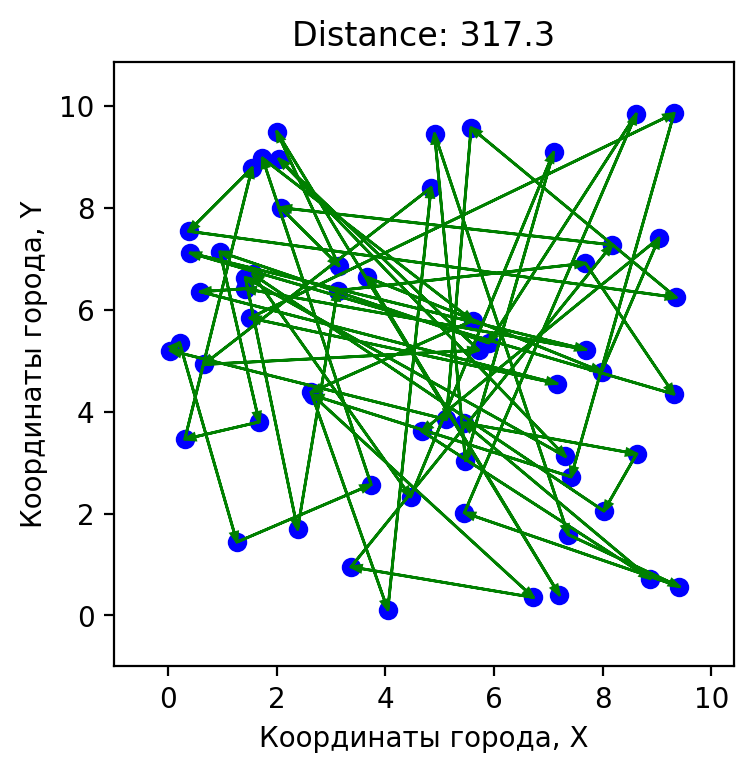

In [12]:
plot_TSP(random_route)

## Генетический алгоритм

Генетический алгоритм (англ. genetic algorithm) — это эвристический алгоритм поиска, используемый для решения задач оптимизации и моделирования путём последовательного подбора, комбинирования и вариации искомых параметров с использованием механизмов, напоминающих биологическую эволюцию. Является разновидностью эволюционных вычислений (англ. evolutionary computation). Отличительной особенностью генетического алгоритма является акцент на использование оператора «скрещивания», который производит операцию рекомбинации решений-кандидатов, роль которой аналогична роли скрещивания в живой природе.

### Описание алгоритма

```{python}
1.Случайным образом генерируется конечный набор пробных решений: P^1=\{p_1^1 ... p_n^1\},\qquad p_i^1\in X  (первое поколение, n - размер популяции).
2.Оценка приспособленности текущего поколения: F^k=\{f_1^k ... f_n^k\},\qquad f_i^k=W(p_i^k) 
3.Выход, если выполняется критерий останова, иначе
4.Генерация нового поколения посредством операторов селекции S, скрещивания C и мутаций M: P^{k+1}=M\cdot C \cdot S (P^k,F^k) и переход к пункту 2.

В процессе селекции выживают отбирают только несколько лучших пробных решений, остальные далее не используются. Скрещивание за место пары решений создаёт другую, элементы которой перемешаны каким-то особым образом. Мутация случайным образом меняет какую-нибудь компоненту пробного решения на иную.
```    


### Применение генетических алгоритмов

```{python}
Оптимизация функций
Оптимизация запросов в базах данных
Разнообразные задачи на графах (задача коммивояжёра, раскраска, нахождение паросочетаний)
Настройка и обучение искусственной нейронной сети
Задачи компоновки
Составление расписаний
Игровые стратегии
Теория приближений
Искусственная жизнь
Биоинформатика (свёртывание белков)
```   

In [13]:
Route = List[City]

def initial_population(population_size: int, city_list: List[City]) -> List[Route]:
    population = [create_random_route(city_list, seed=seed) for seed in range(population_size)]
    return population


In [14]:
def rank_routes(population: List[Route]) -> List[Tuple[int, float]]:
    fitness_results = {}
    for i in range(0,len(population)):
        fitness_results[i] = DistFitness(population[i]).calc_fitness()
    # index -> fitness value
    # сортировка в порядке возрастания дистанции
    return sorted(fitness_results.items(), key = operator.itemgetter(1))


In [15]:
def selection(population_ranked: List[Tuple[int, float]], elite_size: int) -> List[int]:
    selection_results = []
    df = pd.DataFrame(np.array(population_ranked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100 * df.cum_sum / df.Fitness.sum()
    
    for i in range(0, elite_size):
        selection_results.append(population_ranked[i][0])
        
    for _ in range(0, len(population_ranked) - elite_size):
        pick = 100 * random.random()
        for i in range(0, len(population_ranked)):
            # сравниваем случайную величину с кумулятивно рассчитанной вероятностью взятия объекта
            if pick <= df['cum_perc'][i]: 
                selection_results.append(population_ranked[i][0])
                break
    return selection_results


In [16]:
def chose_from_population(population: List[Route], selection_results: List[int]) -> List[Route]:
    pool = []
    for i in range(len(selection_results)):
        index = selection_results[i]
        pool.append(population[index])
    return pool


In [17]:
def breed(parent1: Route, parent2: Route) -> Route:
    child_P1 = []
    child_P2 = []
    
    gene_A = int(random.random() * len(parent1))
    gene_B = int(random.random() * len(parent1))
    
    if gene_A > gene_B:
        gene_A, gene_B = gene_B, gene_A

    child_P1 = parent1[gene_A : gene_B]
    
    child_P2 = [item for item in parent2 if item not in child_P1]
    # склеиваем гены двух родителей
    child = child_P1 + child_P2
    return child


In [18]:
def breed_population(population: List[Route], elite_size: int) -> List[Route]:
    children = []
    length = len(population) - elite_size

    children.extend(population[:elite_size])

    population = random.sample(population, len(population))
    
    for i in range(length):
        child = breed(population[i], population[len(population)-i-1])
        children.append(child)
    return children


In [19]:
def mutate(individual: Route, mutation_rate: float) -> Route:
    for idx_for_swap in range(len(individual)):
        if(random.random() <= mutation_rate):
            idx_swap_with = int(random.random() * len(individual))
            individual[idx_for_swap], individual[idx_swap_with] = individual[idx_swap_with], \
                individual[idx_for_swap]
    return individual


In [20]:
def mutate_population(population: List[Route], mutation_rate: float) -> List[Route]:
    mutated_population = []
    
    for ind in range(len(population)):
        mutated = mutate(population[ind], mutation_rate)
        mutated_population.append(mutated)
    return mutated_population


## Объединим всё вместе

In [21]:
def get_next_generation(current_gen: List[Route], elite_size: int, mutation_rate: float) -> List[Route]:
    # отранжируем популяцию по возрастанию дистанции
    pop_ranked = rank_routes(current_gen)
    # отберем несколько лучших + сколько-то остальных для скрещиваний
    selection_results = selection(pop_ranked, elite_size)
    chosed_individuals = chose_from_population(current_gen, selection_results)
    # произведем скрещивание генов
    children = breed_population(chosed_individuals, elite_size)
    # а затем вызовем мутацию с некоторой вероятностью
    next_generation = mutate_population(children, mutation_rate)
    return next_generation

In [22]:
def genetic_algorithm(
    city_list: List[City], 
    pop_size: int, 
    elite_size: int,
    mutation_rate: float,
    num_generations: int = 10
) -> Route:
    pop = initial_population(pop_size, city_list)
    
    for i in tqdm(range(num_generations)):
        pop = get_next_generation(pop, elite_size, mutation_rate)
    
    best_route_index = rank_routes(pop)[0][0]
    best_route = pop[best_route_index]
    return best_route

In [34]:
best_route_ga = genetic_algorithm(city_list, 25, 5, 0.01, 10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

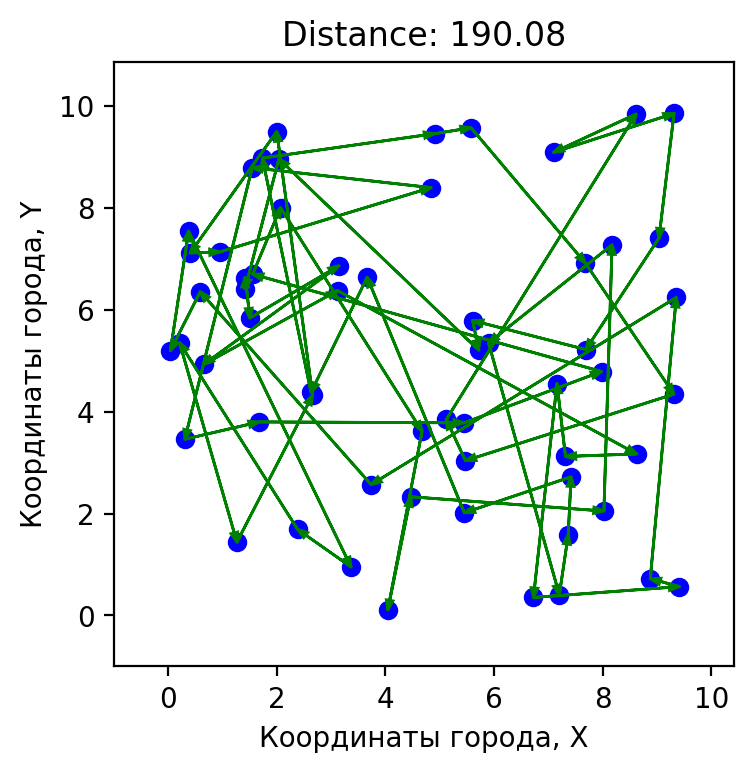

In [35]:
plot_TSP(best_route_ga)

In [36]:
DistFitness(best_route_ga).calc_fitness()

190.08012561527704